In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import operator
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import imageio
import copy

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

import gym

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPG

Uses Q function aproximation as a critic to inform an actor. The actor acts deterministicly in each state. Thus simplifying the Bellman equation from 

$$Q^\pi(s_t,a_t) = \sum_{r_t,s_t+1 ~ E} [r(s_t,a_t) + \gamma\sum a_t+1 ~ \pi [Q^\pi(s_t+1,a_t+1)]]$$
---
$$Q^\mu(s_t,a_t) = \sum_{r_t,s_t+1 ~ E} [r(s_t,a_t) + \gamma Q^\mu(s_t+1,a_t+1)]$$
---
Exploration policy 
    $$ \mu^`(s_t) = \mu(s_t|\theta^\mu_{t}) + N$$

The components of DDPG are

- Replay buffer
- Noise scaler
- Actor network
    - target actor network
- Q network
    - target Q network
- 'Soft' update


## **Algorithm**:
1. Randomly initialize critic and actor networks
2. Randomly initialize target critic and actor networks
3. initialize Replay buffer R
4. for episode = 1,M:
5.    initialize random process N for exploration
6.    Receive initial state S
7.    for t = 1,T:
8.        select action $$a_t = \mu(s_t|\theta^\mu) + N_t$$ according to the policy and exploration noise
9.        execute action a_t and observe reward r_t and new state s_t
10.       store transition $$(s_t,a_t,r_t,s_t+1)$$ in R
11.       sample random minibatch of N transitions in R
12.       $$ Set y_i = r_i + \gamma Q^`(s_t+1,\mu^`(s_t+1|\theta^\mu^`)|\theta^Q^`)$$
13.       update critic by minimizing loss: L = 1/N Sum(y - Q(sa))^2
14.       $$\bigtriangledown_{\theta\mu} J \approx 1/N \sum_i \bigtriangledown_a Q(s,a|\theta^Q)|s=s_i,a=\mu(s_i)\bigtriangledown_{\theta\mu}(s|\theta^\mu)|s+i$$
15.       update actor by the sampled policy gradient
16.       update the target networks


## Networks

In [110]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [111]:
class Critic(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(400,300)):
        super(Critic,self).__init__()
        self.seed = seed
        self.seed = torch.manual_seed(seed)
        self.nS = nS
        self.nA = nA
        
        self.input_layer = nn.Linear(nS,400)
        self.input_bn = nn.BatchNorm1d(400)
        self.fc1 = nn.Linear(400+nA,300)
        self.fc1_bn = nn.BatchNorm1d(300)
        self.output_layer = nn.Linear(300,1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.input_layer.weight.data.uniform_(*hidden_init(self.input_layer))
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.output_layer.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state,action):
        xs = self.input_bn(F.relu(self.input_layer(state)))
        x = torch.cat((xs,action),dim=1)
        x = self.fc1_bn(F.relu(self.fc1(x)))
        return self.output_layer(x)

In [162]:
class Actor(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(400,300)):
        super(Actor,self).__init__()
        
        self.seed = seed
        self.seed = torch.manual_seed(seed)
        self.nS = nS
        self.nA = nA
        self.input_layer = nn.Linear(nS,hidden_dims[0])
        self.fc1 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.output_layer = nn.Linear(hidden_dims[1],nA)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.input_layer.weight.data.uniform_(*hidden_init(self.input_layer))
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.output_layer.weight.data.uniform_(-3e-3,3e-3)
        
    def forward(self,state):
        x = F.relu(self.input_layer(state))
        x = F.relu(self.fc1(x))
        return torch.tanh(self.output_layer(x))

## Replay Buffer and Priority Tree

In [113]:
"""
Priority Tree.
3 tiered tree structure containing
Root node (Object. sum of all lower values)
Intermediate Node (Object. Root as parent, sums a given slice of the priority array)
Priority Array (Array of priorities, length buffer_size)

The number of Intermediate nodes is calculated by the buffer_size / batch_size.

I_episode: current episode of training

Index: is calculated by i_episode % buffer_size. This loops the index after exceeding the buffer_size.

Indices: (List) of memory/priority entries

intermediate_dict: maps index to intermediate node. Since each Intermediate node is responsible 
for a given slice of the priority array, given a particular index, it will return the Intermediate node
'responsible' for that index.

## Functions:

Add:
Calculates the priority of each TD error -> (abs(TD_error)+epsilon)**alpha
Stores the priority in the Priority_array.
Updates the sum_tree with the new priority

Update_Priorities:
Updates the index with the latest priority of that sample. As priorities can change over training
for a particular experience

Sample:
Splits the current priority_array based on the number of entries, by the batch_size.
Returns the indicies of those samples and the priorities.

Propogate:
Propogates the new priority value up through the tree
"""

class PriorityTree(object):
    def __init__(self,buffer_size,batch_size,alpha,epsilon):
        self.alpha = alpha
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.num_intermediate_nodes = math.ceil(buffer_size / batch_size)
        self.current_intermediate_node = 0
        self.root = Node(None)
        self.intermediate_nodes = [Intermediate(self.root,batch_size*x,batch_size*(x+1)) for x in range(self.num_intermediate_nodes)]
        self.priority_array = np.zeros(buffer_size)
        self.intermediate_dict = {}
        for index,node in enumerate(self.intermediate_nodes):
            for key in range((batch_size*(index+1))-batch_size,batch_size*(index+1)):
                self.intermediate_dict[key] = node
        print('Priority Tree: Batch Size {} Buffer size {} Number of intermediate Nodes {}'.format(batch_size,buffer_size,self.num_intermediate_nodes))
        
    def add(self,TD_error,index):
        priority = (abs(TD_error)+self.epsilon)**self.alpha
        self.priority_array[index] = priority
        # Update sum
        propogate(self.intermediate_dict[index],self.priority_array)
    
    def sample(self,index):
        # Sample one experience uniformly from each slice of the priorities
        if index >= self.buffer_size:
            indicies = [random.sample(list(range(sample*self.num_intermediate_nodes,(sample+1)*self.num_intermediate_nodes)),1)[0] for sample in range(self.batch_size)]
        else:
            interval = int(index / self.batch_size)
            indicies = [random.sample(list(range(sample*interval,(sample+1)*interval)),1)[0] for sample in range(self.batch_size)]
        priorities = self.priority_array[indicies]
        return priorities,indicies
    
    def update_priorities(self,TD_errors,indicies):
        priorities = (abs(TD_errors)+self.epsilon)**self.alpha
        self.priority_array[indicies] = priorities
        # Update sum
        nodes = [self.intermediate_dict[index] for index in indicies] 
        intermediate_nodes = set(nodes)
        [propogate(node,self.priority_array) for node in intermediate_nodes]
    
class Node(object):
    def __init__(self,parent):
        self.parent = parent
        self.children = []
        self.value = 0
            
    def add_child(self,child):
        self.children.append(child)
    
    def set_value(self,value):
        self.value = value
    
    def sum_children(self):
        return sum([child.value for child in self.children])
            
    def __len__(self):
        return len(self.children)

class Intermediate(Node):
    def __init__(self,parent,start,end):
        self.parent = parent
        self.start = start
        self.end = end
        self.value = 0
        parent.add_child(self)
    
    def sum_leafs(self,arr):
        return np.sum(arr[self.start:self.end])

def propogate(node,arr):
    if node.parent != None:
        node.value = node.sum_leafs(arr)
        propogate(node.parent,arr)
    else:
        node.value = node.sum_children()

In [88]:
"""
Priority Buffer HyperParameters
alpha(priority or w) dictates how biased the sampling should be towards the TD error. 0 < a < 1
beta(IS) informs the importance of the sample update

The paper uses a sum tree to calculate the priority sum in O(log n) time. As such, i've implemented my own version
of the sum_tree which i call priority tree.

We're increasing beta(IS) from 0.5 to 1 over time
alpha(priority) we're holding constant at 0.5
"""

class PriorityReplayBuffer(object):
    def __init__(self,action_size,buffer_size,batch_size,seed,alpha=0.5,beta=0.5,beta_end=1,beta_duration=1e+5,epsilon=7e-5):
        
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.beta_end = beta_end
        self.beta_duration = beta_duration
        self.beta_increment = (beta_end - beta) / beta_duration
        self.max_w = 0
        self.epsilon = epsilon
        self.TD_sum = 0

        self.experience = namedtuple('experience',field_names=['state','action','reward','next_state','done','i_episode'])
        self.sum_tree = PriorityTree(buffer_size,batch_size,alpha,epsilon)
        self.memory = {}
    
    def add(self,state,action,reward,next_state,done,TD_error,i_episode):
        e = self.experience(state,action,reward,next_state,done,i_episode)
        index = i_episode % self.buffer_size
        # add memory to memory and add corresponding priority to the priority tree
        self.memory[index] = e
        self.sum_tree.add(TD_error,index)

    def sample(self,index):
        # We times the error by these weights for the updates
        # Super inefficient to sum everytime. We could implement the tree sum structure. 
        # Or we could sum once on the first sample and then keep track of what we add and lose from the buffer.
        # priority^a over the sum of the priorities^a = likelyhood of the given choice
        # Anneal beta
        self.update_beta()
        # Get the samples and indicies
        priorities,indicies = self.sum_tree.sample(index)
        # Normalize with the sum
        norm_priorities = priorities / self.sum_tree.root.value
        samples = [self.memory[index] for index in indicies]
        
        # Importance weights
        importances = [(priority * self.buffer_size)**-self.beta for priority in norm_priorities]
        self.max_w = max(self.max_w,max(importances))
        # Normalize importance weights
        norm_importances = [importance / self.max_w for importance in importances]
        
        states = torch.from_numpy(np.vstack([e.state for e in samples if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in samples if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in samples if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in samples if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in samples if e is not None])).float().to(device)
        
#         if index % 4900 == 0:
#             print('beta',self.beta)
#             print('self.max_w',self.max_w)
#             print('len mem',len(self.memory))
#             print('tree sum',self.sum_tree.root.value)
        
        return (states,actions,rewards,next_states,dones),indicies,norm_importances

    def update_beta(self):
        self.beta += self.beta_increment
        self.beta = min(self.beta,self.beta_end)
    
    def __len__(self):
        return len(self.memory.keys())

In [89]:
class ReplayBuffer(object):
    def __init__(self,action_size,buffer_size,batch_size,seed):
        
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple('experience',field_names=['state','action','reward','next_state','done'])
        self.memory = deque(maxlen=buffer_size)
    
    def sample(self):
        experiences = random.sample(self.memory,self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).uint64().to(device)
        
        return (states,actions,rewards,next_states,dones)
            
    
    def add_experience(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e) 
    
    def __len__(self):
        return len(self.memory)

In [150]:
class DDPG(object):
    def __init__(self,nA,nS,BUFFER_SIZE,min_buffer_size,batch_size,seed,L2):
        self.seed = seed
        self.nA = nA
        self.nS = nS
        self.Buffer_size = BUFFER_SIZE
        self.min_buffer_size = min_buffer_size
        self.batch_size = batch_size
        self.L2 = L2
        
        self.R = ReplayBuffer(nA,BUFFER_SIZE,batch_size,seed)
        self.local_critic = Critic(seed,nS,nA)
        self.target_critic = Critic(seed,nS,nA)
        self.local_actor = Actor(seed,nS,nA)
        self.target_actor = Actor(seed,nS,nA)
        self.critic_optimizer = optim.Adam(self.local_critic.parameters(), lr = 1e-3,weight_decay=L2)
        self.actor_optimizer = optim.Adam(self.local_actor.parameters(), lr = 1e-4)
    
    def step(self,state,action,reward,next_state,done):
        # Store tuple
        self.R.add(state,action,reward,next_state,done)
        # Sample memory if len > minimum
        if len(self.R) > self.min_buffer_size:
            # Get experience tuples
            samples = self.R.sample()
            # Learn from them and update local networks
            self.learn(samples)
            # Update target networks
            self.update_networks()
            
    def learn(self,samples):
        states,actions,rewards,next_states,dones = samples
        
        target_actions = self.target_actor(states)
        Q_targets = self.local_critic(states,target_actions)
        target_y = rewards + (gamma*Q_targets*(1-dones))
        
        # update critic
        current_y = self.local_critic(states,actions)
        L = 1/self.batch_size * sum(target_y - current_y)**2
        self.critic_optimizer.zero_grad()
        L.backward()
        self.critic_optimizer.step()
        # update actor
        local_actions = self.local_actor(actions)
        J = 1/self.batch_size * sum(self.local_critic(states,local_actions))
        self.actor_optimizer.zero_grad()
        J.backward()
        self.actor_optimizer.step()
        
    def act(self,state,N):
        
        state = torch.from_numpy(state).float().to(device)
        self.local_actor.eval()
        with torch.no_grad():
            action = self.local_actor(state).cpu().data.numpy()
        # Act with noise
        action = np.clip(action + N,-1,1)
        return action
    
    def update_networks(self):
        self.target_critic = DDPG.soft_update_target(self.current_critic,self.target_critic)
        self.target_actor = DDPG.soft_update_target(self.current_actor,self.target_actor)
        
    @staticmethod
    def soft_update_target(local,target):
        for local_param,target_param in zip(local.parameters(),target.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
        return target

In [151]:
def initialize_N(T):
    """
    Orstein Uhlenbeck process
    theta = 0.15
    sigma = 0.2
    mu = 0
    dX = theta(mu-X) dt + sigma * dW
    """
    theta = 0.15
    sigma = 0.2
    mu = 0
    tau = 2
    dt = 1
    n = int(T / dt)
    
    t = np.linspace(0.,T,n)
    sigma_bis = sigma * np.sqrt(2. / tau)
    sqrtdt = np.sqrt(dt)
    x = np.zeros(n)
    
    for i in range(1,n):
        x[i] = x[i-1] + dt * (-(x[i-1] - mu)/tau) + \
            sigma_bis * sqrtdt * np.random.randn()
        
    return x
#     N = theta(-X) * dt + sigma * W
    
#     X += dt * (-(X - mu) / tau) + \
#         sigma * np.random.randn(ntrials)

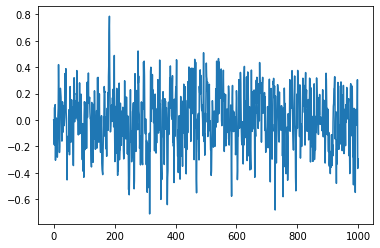

In [169]:
x = initialize_N(1000)
plt.plot(x)

In [159]:
def train(agent,env,n_episodes=500, tmax=200):
    """Deep Deterministic Policy Gradients.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        Instead of updating target every (int) steps, using 'soft' updating of .1 to gradually merge the networks
    """
    scores = []
    scores_window = deque(maxlen=100)
    index = 0
    
    N = initialize_N(n_episodes)
    for e in range(1,n_episodes):
        state = env.reset()
        score = 0
        for t in range(1,tmax):
            action = agent.act(state,N[e])[0]
            print('action',action)
            next_state,reward,done = env.step(action)
            # store memory and learn
            agent.step(state,action,reward,next_state,done)
            # Bookkeeping
            state = next_state
            score += reward
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

In [160]:
BUFFER_SIZE = 10000
MIN_BUFFER_SIZE = 200
BATCH_SIZE = 50
ALPHA = 0.6 # 0.7 or 0.6
START_BETA = 0.5 # from 0.5-1
END_BETA = 1
QLR = 0.001
ALR = 0.0001
EPSILON = 1
MIN_EPSILON = 0.01
GAMMA = 0.99
TAU = 0.001
L2 = 0.01
UPDATE_EVERY = 4
CLIP_NORM = 10
    
def main():
    seed = 7
    env = gym.make('CartPole-v0')
    env.seed(seed)
    nA = env.action_space.n
    nS = env.observation_space.shape[0]
    print('Observation Space {}, Action Space {}'.format(nS,nA))
    agent = DDPG(nA,nS,BUFFER_SIZE,MIN_BUFFER_SIZE,BATCH_SIZE,seed,L2)
    scores = train(agent,env)
    return scores

In [161]:
scores = main()
plot.plt(scores)

Observation Space 4, Action Space 2
action 0.30357128


AssertionError: 0.30357128 (<class 'numpy.float32'>) invalid

In [166]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

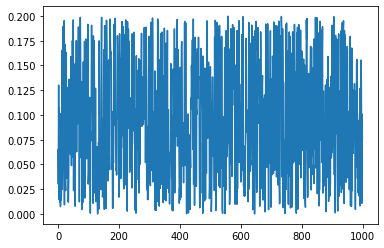

In [168]:
N = OUNoise(1000,7)
data = N.sample()
plt.plot(data)